In [1]:
import os
import sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud
from datetime import datetime, timedelta

In [2]:
os.chdir('..') 

In [3]:
from src.loader import SlackDataLoader

In [4]:
from src.config import cfg

Output File: slack_data.csv
Path: data\Anonymized_B6SlackExport_25Nov23\anonymized
Channel: data\Anonymized_B6SlackExport_25Nov23\anonymized\channels.json
Userfile: data\Anonymized_B6SlackExport_25Nov23\anonymized\users.json


In [5]:
import src.utils as utils

In [6]:
slack_data_loader = SlackDataLoader(cfg.path)

In [13]:
user_names_by_id, user_ids_by_name = slack_data_loader.get_user_map()

In [14]:
def calculate_user_metrics(messages):
    user_metrics = {}

    for message in messages:
        user_id = message.get('user')
        if user_id is not None:
            user_name = user_names_by_id.get(user_id)
            if user_name is not None:
                # Initialize metrics if the user is not in the dictionary
                if user_name not in user_metrics:
                    user_metrics[user_name] = {'Reply count': 0, 'Mention count': 0, 'Message count': 0}

                # Update metrics
                user_metrics[user_name]['Reply count'] += message.get('reply_count', 0)
                user_metrics[user_name]['Mention count'] += message.get('mention_count', 0)
                user_metrics[user_name]['Message count'] += 1

    return user_metrics

In [17]:
# Analyze each channel
all_channel_messages = []
for channel in slack_data_loader.channels:
    channel_name = channel['name']
    channel_messages = slack_data_loader.get_channel_messages(channel_name)
    all_channel_messages.extend(channel_messages)

In [18]:
# Calculate user metrics for all messages
user_metrics = calculate_user_metrics(all_channel_messages)

In [19]:
user_metrics_df = pd.DataFrame.from_dict(user_metrics, orient='index')

In [20]:
top_users_reply = user_metrics_df.sort_values(by='Reply count', ascending=False).head(10)
bottom_users_reply = user_metrics_df.sort_values(by='Reply count').head(10)

In [21]:
print(top_users_reply)

          Reply count  Mention count  Message count
Cristian          727              0            902
Vanessa           614              0           1554
Brenda            453              0            910
Brian             443              0            458
Travis            435              0           1178
Amy               414              0           1206
Judith            378              0            675
April             363              0           1070
Michelle          355              0            473
Brady             341              0            706


In [22]:
print(bottom_users_reply)

          Reply count  Mention count  Message count
Paul                0              0              1
Blake               0              0              4
Erica               0              0              5
Nicole              0              0             18
Glen                0              0             13
Patricia            0              0             31
Holly               0              0              6
David               0              0              3
Claudia             0              0              4
Patrick             1              0             27


In [23]:
top_users_mention = user_metrics_df.sort_values(by='Mention count', ascending=False).head(10)
bottom_users_mention = user_metrics_df.sort_values(by='Mention count').head(10)

In [24]:
print(top_users_mention)

          Reply count  Mention count  Message count
Garrett            28              0            222
Melissa             7              0             37
Phillip           273              0            803
Samuel             85              0            162
Judith            378              0            675
Ashley            257              0            411
Vernon              6              0             39
Cheryl             60              0            189
Michelle          355              0            473
Leah               11              0             14


In [25]:
print(bottom_users_mention)

          Reply count  Mention count  Message count
Garrett            28              0            222
Phillip           273              0            803
Samuel             85              0            162
Judith            378              0            675
Ashley            257              0            411
Vernon              6              0             39
Cheryl             60              0            189
Michelle          355              0            473
Leah               11              0             14
Michael            38              0            337


In [26]:
top_users_message = user_metrics_df.sort_values(by='Message count', ascending=False).head(10)
bottom_users_message = user_metrics_df.sort_values(by='Message count').head(10)

In [27]:
print(top_users_message)

          Reply count  Mention count  Message count
Vanessa           614              0           1554
Amy               414              0           1206
Travis            435              0           1178
April             363              0           1070
Brenda            453              0            910
Cristian          727              0            902
Phillip           273              0            803
Brady             341              0            706
Judith            378              0            675
Joshua            308              0            575


In [28]:
print(bottom_users_message)

             Reply count  Mention count  Message count
Paul                   0              0              1
Audrey                 8              0              3
David                  0              0              3
Claudia                0              0              4
Blake                  0              0              4
Erica                  0              0              5
Holly                  0              0              6
Christopher            4              0              7
Glen                   0              0             13
Leah                  11              0             14


In [29]:
# Function to calculate reaction count for each user
def calculate_reaction_count(messages):
    reaction_count = {}

    for message in messages:
        user_id = message.get('user')
        reactions = message.get('reactions', [])

        if user_id is not None:
            user_name = user_names_by_id.get(user_id)
            if user_name is not None:
                # Initialize reaction count if the user is not in the dictionary
                if user_name not in reaction_count:
                    reaction_count[user_name] = 0

                # Update reaction count
                reaction_count[user_name] += len(reactions)

    return reaction_count

In [30]:
reaction_count = calculate_reaction_count(all_channel_messages)
reaction_count_df = pd.DataFrame.from_dict(reaction_count, orient='index', columns=['Reaction count'])

In [31]:
top_users_reaction = reaction_count_df.sort_values(by='Reaction count', ascending=False).head(10)
bottom_users_reaction = reaction_count_df.sort_values(by='Reaction count').head(10)

In [32]:
print(top_users_reaction)

          Reaction count
Vanessa              427
April                335
Amy                  332
Travis               248
Cristian             243
Judith               236
Brady                223
Phillip              222
Joshua               196
Brian                190


In [33]:
print(bottom_users_reaction)

         Reaction count
Paul                  0
Holly                 0
David                 0
Nicole                0
Claudia               0
Glen                  0
Audrey                0
Erica                 0
Blake                 0
Randy                 1


In [34]:
# Function to extract messages with their metadata
def extract_messages_with_metadata(messages):
    extracted_messages = []

    for message in messages:
        user_id = message.get('user')
        user_name = user_names_by_id.get(user_id)
        timestamp = message.get('ts')
        text = message.get('text', '')
        reply_count = message.get('reply_count', 0)
        reaction_count = len(message.get('reactions', []))
        mention_count = message.get('mention_count', 0)

        extracted_messages.append({
            'User': user_name,
            'Timestamp': timestamp,
            'Text': text,
            'Reply count': reply_count,
            'Reaction count': reaction_count,
            'Mention count': mention_count
        })

    return extracted_messages

In [35]:
messages_with_metadata = extract_messages_with_metadata(all_channel_messages)

In [36]:
messages_df = pd.DataFrame(messages_with_metadata)

In [37]:
top_messages_by_replies = messages_df.sort_values(by='Reply count', ascending=False).head(10)
top_messages_by_reactions = messages_df.sort_values(by='Reaction count', ascending=False).head(10)
top_messages_by_mentions = messages_df.sort_values(by='Mention count', ascending=False).head(10)

In [38]:
print(top_messages_by_replies)

          User          Timestamp  \
17548     Mark  1665161559.335679   
8102     Brian  1668169350.223689   
2332    Steven  1663072090.617319   
16839    Brady  1664916746.043439   
6703     Brian  1666700374.650289   
11701   Yvonne  1666900816.202839   
10842  Anthony  1662400744.293029   
11245   Judith  1666778289.497499   
12822  Vanessa  1667286619.471889   
18429   Ashley  1666858629.076399   

                                                    Text  Reply count  \
17548  <!here> I'm getting this error when I try to p...          168   
8102           <@U03V1AM5TFA> how many crushes you have?           75   
2332   First Impression: People think I am older than...           63   
16839  1. How do I find my jupyter notebook file in m...           61   
6703   How many here follow football so much? I think...           57   
11701  if Meta stock's decline continues like this,Fa...           57   
10842                    Ethiopian New year Loading ....           54   
11245   

In [39]:
print(top_messages_by_reactions)

            User          Timestamp  \
18306  Katherine  1666962823.974699   
9167        Luis  1666617813.618849   
9267   Katherine  1668174930.647689   
4812       Brady  1665404186.146279   
1301     Vanessa  1662015986.569899   
537       Joshua  1661343645.627299   
6641     Vanessa  1666699201.519759   
6967     Vanessa  1666895793.439309   
11387      April  1667700160.574059   
74         Nancy  1661170288.907809   

                                                    Text  Reply count  \
18306  <@U03UJGP0C68> <@U03UUR571A5> <@U03V785NLSU> p...            0   
9167   <!channel>\nThere will be no careers exercise ...            0   
9267   Who wants to know the secret to great intervie...            4   
4812   High: working in a group, united won, CR7 700\...            0   
1301   *<!here>* Good morning Community! We are very ...            0   
537    My nose is too big I wispher with a straw. I a...            8   
6641   *RING, RING, RIIIIIIIINGGGGG!!!* :phone:*<!her...   

In [40]:
print(top_messages_by_mentions)

           User          Timestamp                                   Text  \
0       Garrett  1660301317.785879  <@U03TEPYRM2P> has joined the channel   
13336    Steven  1661704582.743629  <@U03U1FQKEMV> has joined the channel   
13343  Brittany  1661704583.135599  <@U03UKL27B0R> has joined the channel   
13342  Veronica  1661704583.079989  <@U03UUMM7Y8H> has joined the channel   
13341      Eric  1661704583.024669  <@U03UUN8M4RX> has joined the channel   
13340     Randy  1661704582.970739  <@U03UD63A8PP> has joined the channel   
13339  Samantha  1661704582.913749  <@U03UL5LSTG9> has joined the channel   
13338  Michelle  1661704582.853759  <@U03UJN29Y4C> has joined the channel   
13337  Jennifer  1661704582.799139  <@U03UG1Z21JP> has joined the channel   
13335       Amy  1661704582.688899  <@U03UUR571A5> has joined the channel   

       Reply count  Reaction count  Mention count  
0                0               0              0  
13336            0               0              

In [45]:
# Function to calculate activity metrics for each channel
def calculate_channel_activity(channels):
    channel_activity = {}

    for channel in channels:
        channel_name = channel['name']
        channel_messages = slack_data_loader.get_channel_messages(channel_name)

        message_count = len(channel_messages)
        reply_count = sum(message.get('reply_count', 0) for message in channel_messages)
        reaction_count = sum(len(message.get('reactions', [])) for message in channel_messages)

        channel_activity[channel_name] = {
            'Message count': message_count,
            'Reply and Reaction count': reply_count + reaction_count
        }

    return channel_activity

In [46]:
channel_activity = calculate_channel_activity(slack_data_loader.channels)

In [47]:
channel_activity_df = pd.DataFrame.from_dict(channel_activity, orient='index')

In [48]:
most_active_channel = channel_activity_df.idxmax(axis=0)['Reply and Reaction count']

In [50]:
print(most_active_channel)

all-community-building


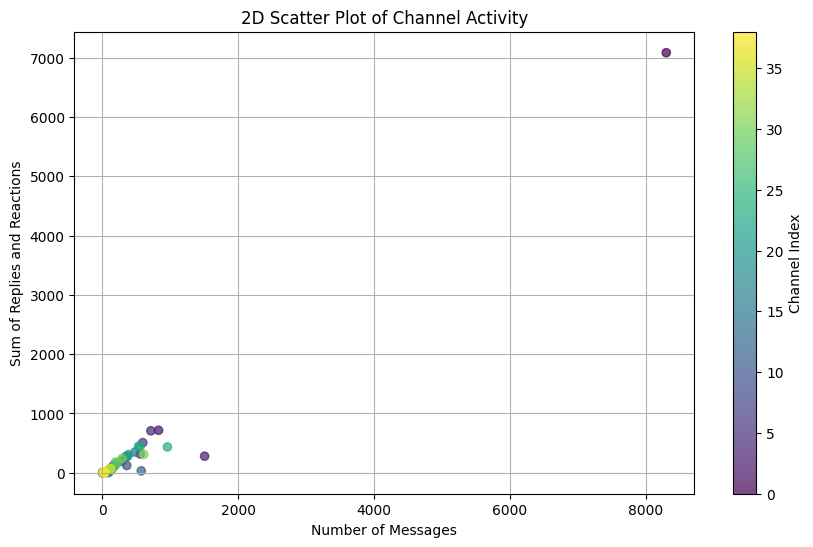

In [51]:
# Plot 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(channel_activity_df['Message count'], channel_activity_df['Reply and Reaction count'], c=range(len(channel_activity_df)), cmap='viridis', alpha=0.7)
plt.colorbar(label='Channel Index')
plt.title('2D Scatter Plot of Channel Activity')
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Replies and Reactions')
plt.grid(True)
plt.show()

In [92]:
# Function to calculate the time difference between two Unix timestamps
def calculate_time_difference_unix(timestamp1, timestamp2):
    return (float(timestamp2) - float(timestamp1)) / 60.0  # Convert to minutes

In [93]:
# Function to calculate the fraction of messages replied within the first 5 minutes
def calculate_fraction_replied_within_5_minutes(messages):
    replied_within_5_minutes = 0
    total_messages = len(messages)

    for message in messages:
        message_timestamp = float(message.get('ts'))
        replies = message.get('replies', [])

        if replies:
            first_reply_timestamp = float(replies[0].get('ts'))
            time_difference = calculate_time_difference_unix(message_timestamp, first_reply_timestamp)

            if time_difference <= 5:
                replied_within_5_minutes += 1

    return replied_within_5_minutes / total_messages


In [94]:
fraction_replied_within_5_minutes = calculate_fraction_replied_within_5_minutes(all_channel_messages)

In [104]:
print(f"\nThe fraction of messages replied within the first 5 minutes is: {fraction_replied_within_5_minutes:.2%}")


The fraction of messages replied within the first 5 minutes is: 6.77%


In [114]:
# Function to extract data for the 2D scatter plot
def extract_scatter_plot_data(messages):
    scatter_plot_data = []

    for message in messages:
        user_id = message.get('user')
        user_name = user_names_by_id.get(user_id)
        timestamp = float(message.get('ts'))
        replies = message.get('replies', [])

        if replies:
            first_reply_timestamp = float(replies[0].get('ts'))
            time_difference = calculate_time_difference_unix(timestamp, first_reply_timestamp)
            time_of_day = (timestamp % (24 * 3600)) / 3600.0  # Convert to hours

            # Use channel index as color
            channel = next((channel for channel in slack_data_loader.channels if channel['id'] == message.get('channel')), None)
            channel_index = slack_loader.channels.index(channel) if channel is not None else -1
            
            scatter_plot_data.append({
                'Time Difference (minutes)': time_difference,
                'Time of Day (hours)': time_of_day,
                'Channel Index': channel_index
            })

    return scatter_plot_data

In [115]:
# Extract data for the 2D scatter plot
scatter_plot_data = extract_scatter_plot_data(all_channel_messages)

In [116]:
scatter_plot_df = pd.DataFrame(scatter_plot_data)

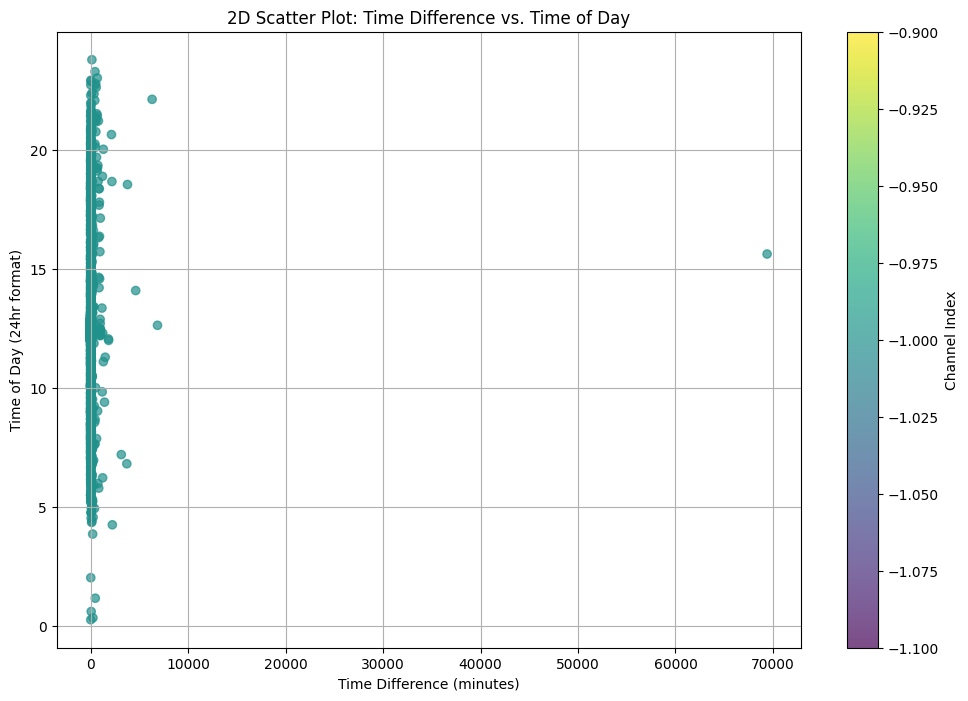

In [117]:
# Plot 2D scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(scatter_plot_df['Time Difference (minutes)'], scatter_plot_df['Time of Day (hours)'], c=scatter_plot_df['Channel Index'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Channel Index')
plt.title('2D Scatter Plot: Time Difference vs. Time of Day')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Time of Day (24hr format)')
plt.grid(True)
plt.show()